In [1]:
import talib as ta
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
#Import data from file saved on system
Infy = pd.read_csv('Infy-His-data2018-20.csv')
print (Infy.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2018-01-01  518.849976  522.250000  515.000000  516.775024  474.472595   
1  2018-01-02  518.625000  521.000000  511.500000  514.849976  472.705139   
2  2018-01-03  514.250000  515.799988  509.299988  510.649994  468.848938   
3  2018-01-04  510.500000  510.500000  504.799988  507.700012  466.140472   
4  2018-01-05  507.649994  513.200012  503.000000  506.000000  464.579559   

     Volume  
0   5431340  
1   6112248  
2   6846552  
3   8947614  
4  11025976  


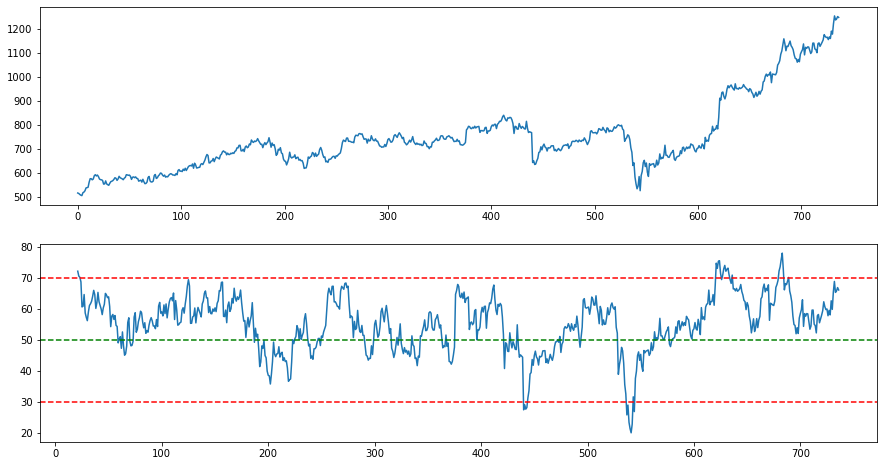

In [3]:
# Compute RSI in colum 'RSI' in Table 'Infy' 
Infy['RSI'] = ta.RSI(Infy['Close'],21)

fig, axs = plt.subplots(2,figsize=(15,8))
axs[0].plot(Infy['Close'])
axs[1].plot(Infy['RSI'])
plt.axhline(70, color='red', linestyle='--') 
plt.axhline(50, color='green', linestyle='--')
plt.axhline(30, color='red', linestyle='--') 

In [4]:
# Compute MACD in colums 'macd', 'macdsignal' & 'macdhist' in Table 'Infy' 
Infy['macd'], Infy['macdsignal'], Infy['macdhist'] = ta.MACD(Infy['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

Infy.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,macd,macdsignal,macdhist
732,2020-12-23,1238.000000,1258.849976,1230.550049,1253.050049,1253.050049,15878346,68.771950,26.403592,19.274116,7.129477
733,2020-12-24,1249.900024,1249.900024,1226.000000,1236.050049,1236.050049,7313885,65.233013,28.655448,21.150382,7.505066
734,2020-12-28,1238.449951,1248.000000,1236.000000,1240.300049,1240.300049,4607051,65.696386,30.432197,23.006745,7.425452
735,2020-12-29,1235.000000,1254.449951,1235.000000,1250.300049,1250.300049,6878105,66.789924,32.275151,24.860426,7.414725
736,2020-12-30,1253.000000,1253.300049,1238.150024,1246.800049,1246.800049,5194690,66.016525,33.072051,26.502751,6.569300


<AxesSubplot:>

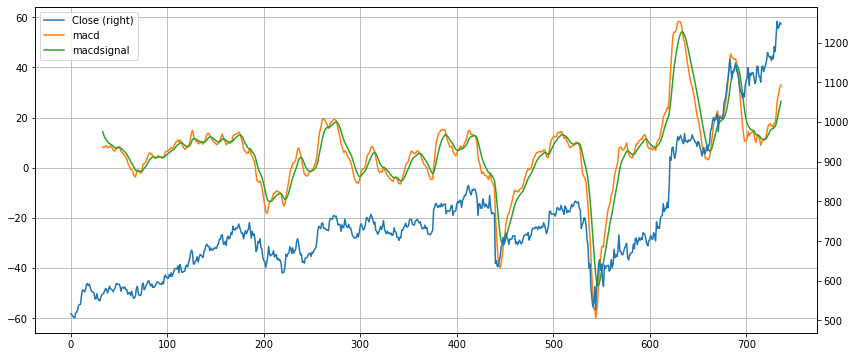

In [5]:
Infy[['Close', 'macd', 'macdsignal']].plot(grid=True, secondary_y='Close', figsize=(14,6))

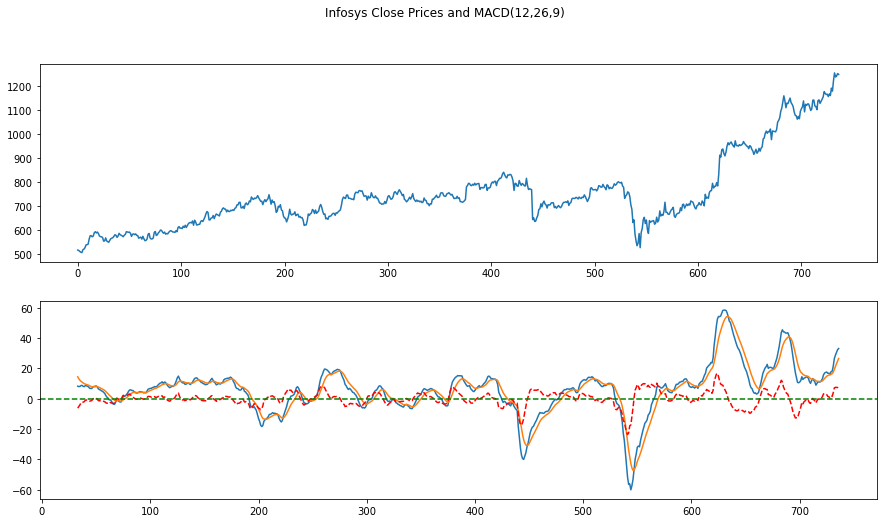

In [6]:
fig1, ax = plt.subplots(2, figsize=(15,8))
ax[0].plot(Infy['Close'])
ax[1].plot(Infy['macd'])
ax[1].plot(Infy['macdsignal'])
ax[1].plot(Infy['macdhist'], color='red', linestyle='--')
plt.axhline(0, color='green', linestyle='--') 
plt.suptitle('Infosys Close Prices and MACD(12,26,9)')
plt.show()

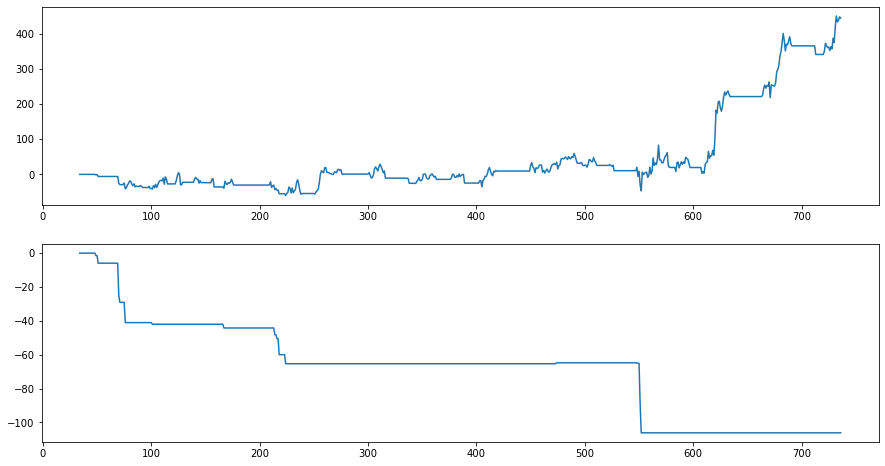

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Calculate trades and profits generated by strategy Buying Infosys when MACD is crosses MACDSignal line upwards and hold position until it crosses downwards
Infy['positions_long'] = np.nan

for x in range (len(Infy)):
    if Infy.macd[x] > Infy.macdsignal[x]:
        Infy['positions_long'][x] = 1
    if Infy.macd[x] <= Infy.macdsignal[x]:
        Infy['positions_long'][x] = 0

Infy.positions_long = Infy.positions_long.fillna(method='ffill')  

Infy['price_difference']= Infy.Close - Infy.Close.shift(1)
Infy['pnllong'] = Infy.positions_long.shift(1) * Infy.price_difference
Infy['cumpnl_long'] = Infy.pnllong.cumsum()

# Calculate the max drawdown in the past window days for each day 
Infy['rolling_max'] = Infy['cumpnl_long'].rolling(250, min_periods=1).max()
Infy['daily_drawdown'] = Infy['cumpnl_long']-Infy['rolling_max']

# Calculate the minimum (negative) daily drawdown
Infy['max_daily_drawdown'] = Infy['daily_drawdown'].rolling(250, min_periods=1).min()

# Plot Cumulative retruns and maximum drawdown of strategy
fig, axs = plt.subplots(2,figsize=(15,8))
axs[0].plot(Infy['cumpnl_long'])
axs[1].plot(Infy['max_daily_drawdown'])


Number of Trade count 26


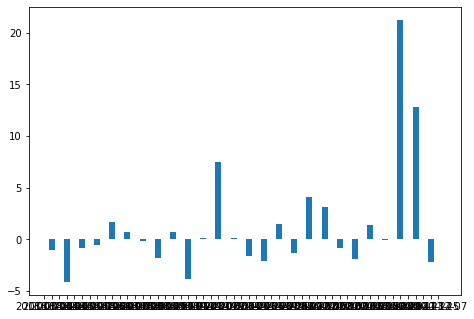

In [8]:
# Calculate number of trades and return of each trade
Infy['Trade'] = Infy['positions_long'].diff()
T2 = Infy.where((Infy.Trade != 0)) 
T2 = T2.dropna()
T2.drop(["positions_long", "price_difference", "pnllong", "rolling_max", "daily_drawdown", "max_daily_drawdown"], axis = 1, inplace = True)
T2['Trade_Return'] = (T2['cumpnl_long'].diff()/T2['Close'])*100
print ("Number of Trade count", round(len(T2)/2))

# Plot trade retruns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(T2['Date'], T2['Trade_Return'])
plt.show()